In [1]:
from typing import List

import torch as ch
import torch.nn as nn
import torchvision

from ffcv.fields import IntField, RGBImageField
from ffcv.fields.decoders import IntDecoder, SimpleRGBImageDecoder
from ffcv.loader import Loader, OrderOption
from ffcv.pipeline.operation import Operation
from ffcv.transforms import RandomHorizontalFlip, Cutout, \
    RandomTranslate, Convert, ToDevice, ToTensor, ToTorchImage
from ffcv.transforms.common import Squeeze
from ffcv.writer import DatasetWriter

In [2]:
ch.cuda.is_available()

True

In [3]:
from torch.utils.data import RandomSampler
#train = torchvision.datasets.CIFAR100('/tmp', train=True, download=True)
#indices = ch.randperm(len(train))[:2500]  #5%: 2500,  20%:10000 
#train_dataset = RandomSampler(train, replacement=False, num_samples=2500)  #  Subset(train, indices)

datasets = {
    'train': torchvision.datasets.CIFAR100('/tmp', train=True, download=True),
    'test': torchvision.datasets.CIFAR100('/tmp', train=False, download=True)
}

for (name, ds) in datasets.items():
    writer = DatasetWriter(f'/tmp/cifar_{name}.beton', {
        'image': RGBImageField(),
        'label': IntField()
    })
    writer.from_indexed_dataset(ds)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 24826.78it/s]


In [4]:
CIFAR_MEAN = [125.307, 122.961, 113.8575]
CIFAR_STD = [51.5865, 50.847, 51.255]

BATCH_SIZE = 128

loaders = {}
for name in ['train', 'test']:
    label_pipeline: List[Operation] = [IntDecoder(), ToTensor(), ToDevice('cuda:0'), Squeeze()]
    image_pipeline: List[Operation] = [SimpleRGBImageDecoder()]

    # Add image transforms and normalization
    if name == 'train':
        image_pipeline.extend([
            RandomTranslate(padding=4),
            RandomHorizontalFlip()
            #Cutout(8, tuple(map(int, CIFAR_MEAN))), # Note Cutout is done before normalization.
        ])
    image_pipeline.extend([
        ToTensor(),
        ToDevice('cuda:0', non_blocking=True),
        ToTorchImage(),
        Convert(ch.float32),
        torchvision.transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ])

    # Create loaders
    loaders[name] = Loader(f'/tmp/cifar_{name}.beton',
                            batch_size=BATCH_SIZE,
                            num_workers=8,
                            order=OrderOption.RANDOM,
                            drop_last=(name == 'train'),
                            pipelines={'image': image_pipeline,
                                       'label': label_pipeline})

In [5]:
import torch
import torch.nn as nn
#import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

def pair(x):
    return x if isinstance(x, tuple) else (x,x)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)
    
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout=0.1):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.1):
        super(Attention, self).__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim), 
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda x: rearrange(x, 'b n (h d) -> b h n d', h=self.heads), qkv)  #b head sequence_len embed_size

        qk = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attention = self.softmax(qk)
        attention = self.dropout(attention)

        out = torch.matmul(attention, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim=1024, dropout=0.1):
        super(Transformer, self).__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x 

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim=1024, pool='cls', channels=3, dim_head=64, dropout=0.1, embed_dropout=0.1):
        super(ViT, self).__init__()
        image_h, image_w = pair(image_size)
        patch_h, patch_w = pair(patch_size)
        assert image_h % patch_h == 0 and image_w % patch_w == 0

        num_patches = (image_h // patch_h) * (image_w // patch_w)
        patch_dim = channels * patch_h * patch_w
        assert pool in {'cls', 'mean'}

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_h, p2=patch_w),
            nn.Linear(patch_dim, dim)
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim)) # 1 is cls_token 
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.embed_dropout = nn.Dropout(embed_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        self.pool = pool 
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    
    def forward(self, x):
        x = self.to_patch_embedding(x)
        b, n, _ = x.shape
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n+1)]
        x = self.embed_dropout(x)
        x = self.transformer(x)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        out = self.mlp_head(x)
        return out 


def test():
    v = ViT(
        image_size = 256,
        patch_size = 32,
        num_classes = 100,
        dim = 1024,
        depth = 6,
        heads = 16,
        mlp_dim = 1024,
        dropout = 0.1,
        embed_dropout = 0.1
    )

    img = torch.randn(1, 3, 256, 256)

    preds = v(img)
    assert preds.shape == (1, 100)

In [6]:
def plot_train_val(train_loss, val_loss):
    e = len(train_loss)
    x_axis = np.arange(1, e + 1, 1)
    plt.figure()
    plt.plot(x_axis, train_loss, label="Training Loss")
    plt.plot(x_axis, val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.legend(loc='best')
    plt.title("Loss Stats Plot")
    plt.show()

In [7]:
import matplotlib.pyplot as plt
def plot_stats(losses):
    e = len(losses)
    x_axis = np.arange(1, e + 1, 1)
    plt.figure()
    plt.plot(x_axis, losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.legend(loc='best')
    plt.title("Training Loss Stats Plot")
    plt.show()

In [8]:
NUM_CLASSES = 100
model = ViT(
        image_size = 32,
        patch_size = 4,
        num_classes = 100,
        dim = 512,
        depth = 6,
        heads = 16,
        mlp_dim = 1024,
        dropout = 0.1,
        embed_dropout = 0.1
    )
model = model.to(memory_format=ch.channels_last).cuda()

In [9]:
import numpy as np
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, lr_scheduler, Adam

EPOCHS = 120
#EPOCHS = 50

opt = Adam(model.parameters(), lr= 1e-3, weight_decay=1e-4)
lr_scheduler1 = lr_scheduler.ConstantLR(opt, factor=1, total_iters=31)
lr_scheduler2 = lr_scheduler.StepLR(opt, step_size=30, gamma=0.3)

lambda1 = lambda epoch: 0.95 ** epoch
scheduler2 = lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)
scheduler1 = lr_scheduler.ConstantLR(opt, factor=1, total_iters=21)
#scheduler = lr_scheduler.SequentialLR(opt, schedulers=[scheduler1, scheduler2], milestones=[21])

#scheduler = lr_scheduler.ReduceLROnPlateau(opt, factor=0.3, patience=5)
#scheduler = lr_scheduler.LinearLR(opt, start_factor=0.9)

scaler = GradScaler()
loss_fn = CrossEntropyLoss(label_smoothing=0.1).cuda()

In [23]:
warmup_scheduler = lr_scheduler.LinearLR(opt, start_factor = 0.01, total_iters = 5)
scheduler_const = lr_scheduler.ConstantLR(opt, factor=1, total_iters=5)
plateau_scheduler = lr_scheduler.ReduceLROnPlateau(opt, factor=0.3, patience = 4)
scheduler = lr_scheduler.SequentialLR(opt, schedulers=[warmup_scheduler, scheduler_const, plateau_scheduler], milestones=[5, 10])

In [10]:
opt = Adam(model.parameters(), lr= 3e-3, weight_decay=1e-4)
lr_scheduler1 = lr_scheduler.ConstantLR(opt, factor=1, total_iters=81)
lr_scheduler2 = lr_scheduler.ExponentialLR(opt, gamma=0.9)
scheduler = lr_scheduler.SequentialLR(opt, schedulers=[lr_scheduler1, lr_scheduler2], milestones=[81])

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0  Training loss: 4.508483357307238 Val loss: 4.298853982852984


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1  Training loss: 4.20600802837274 Val loss: 4.079113453249388


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2  Training loss: 4.072596757839888 Val loss: 3.9807754377775555


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3  Training loss: 3.9940786624566105 Val loss: 3.9164114813261395


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4  Training loss: 3.9430919097020074 Val loss: 3.89156436014779


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5  Training loss: 3.9086284496845343 Val loss: 3.829510094244269


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6  Training loss: 3.8780000436000335 Val loss: 3.788258235665816


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7  Training loss: 3.8219478943409064 Val loss: 3.728048294405394


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8  Training loss: 3.7896677328990056 Val loss: 3.719407286825059


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9  Training loss: 3.77412637869517 Val loss: 3.7010342682464215


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10  Training loss: 3.73532566963098 Val loss: 3.6355887606174133


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11  Training loss: 3.6876184818072195 Val loss: 3.6423145155363446


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12  Training loss: 3.661639821223724 Val loss: 3.6256465308273893


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13  Training loss: 3.627024410932492 Val loss: 3.5674884470203256


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14  Training loss: 3.5985623384133363 Val loss: 3.51156827769702


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15  Training loss: 3.559778616978572 Val loss: 3.446205679374405


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16  Training loss: 3.5323450999382215 Val loss: 3.445346621018422


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17  Training loss: 3.5068527087187156 Val loss: 3.431337543680698


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18  Training loss: 3.467904121447832 Val loss: 3.3590911702264714


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19  Training loss: 3.4332338467622416 Val loss: 3.3248105169851567


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 20  Training loss: 3.408420581695361 Val loss: 3.3177148601676842


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 21  Training loss: 3.375389586962186 Val loss: 3.298036774502525


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 22  Training loss: 3.331178064835377 Val loss: 3.222414264196082


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 23  Training loss: 3.288888354179187 Val loss: 3.181718750845028


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 24  Training loss: 3.233818803078089 Val loss: 3.14988239505623


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 25  Training loss: 3.1963188024667595 Val loss: 3.094040019602715


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 26  Training loss: 3.1682724964924347 Val loss: 3.0975486930412583


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 27  Training loss: 3.1446354853801237 Val loss: 3.037760158128376


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 28  Training loss: 3.122498740294041 Val loss: 3.0280584383614455


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 29  Training loss: 3.1030812208469096 Val loss: 2.9769266013857685


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 30  Training loss: 3.0910742081128633 Val loss: 2.992712425280221


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 31  Training loss: 3.0693104395499597 Val loss: 2.9496151616301716


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 32  Training loss: 3.061035525493133 Val loss: 2.9204286110552053


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 33  Training loss: 3.035886066387861 Val loss: 2.9605516210387024


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 34  Training loss: 3.019951050098126 Val loss: 2.917207636410677


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 35  Training loss: 3.010711839871529 Val loss: 2.9037059138092816


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 36  Training loss: 2.991889149103409 Val loss: 2.8875938367240037


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 37  Training loss: 2.980406562487284 Val loss: 2.8816543017761616


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 38  Training loss: 2.975329367319743 Val loss: 2.8755375463751296


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 39  Training loss: 2.9592398301149028 Val loss: 2.8674702402911607


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 40  Training loss: 2.9569664478302 Val loss: 2.865333638613737


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 41  Training loss: 2.945400160398239 Val loss: 2.837759796577164


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 42  Training loss: 2.940068269998599 Val loss: 2.889074050927464


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 43  Training loss: 2.93615661523281 Val loss: 2.787256678448448


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 44  Training loss: 2.9188838445223295 Val loss: 2.833713839325724


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 45  Training loss: 2.9196068592560596 Val loss: 2.8109511031380183


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 46  Training loss: 2.913982129096985 Val loss: 2.8160455800309965


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 47  Training loss: 2.9065150982294328 Val loss: 2.7911252884925166


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 48  Training loss: 2.9022467692693072 Val loss: 2.8104318848139123


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 49  Training loss: 2.8947016881062435 Val loss: 2.8202213697795626


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 50  Training loss: 2.891016612908779 Val loss: 2.8134014365039293


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 51  Training loss: 2.887397674413828 Val loss: 2.7859863963308213


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 52  Training loss: 2.885704488020677 Val loss: 2.7590659690808645


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 53  Training loss: 2.876990572000161 Val loss: 2.770401912399485


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 54  Training loss: 2.8809078381611752 Val loss: 2.786956769001635


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 55  Training loss: 2.8722138991722694 Val loss: 2.7915033931973614


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 56  Training loss: 2.861378276042449 Val loss: 2.7625408263146123


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 57  Training loss: 2.858886965115865 Val loss: 2.7756889560554603


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 58  Training loss: 2.8534486654477242 Val loss: 2.7508829183216337


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 59  Training loss: 2.851602676587227 Val loss: 2.7598790398126916


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 60  Training loss: 2.850934799512227 Val loss: 2.736546447005453


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 61  Training loss: 2.8513314546682897 Val loss: 2.7379536025131803


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 62  Training loss: 2.8415627124982 Val loss: 2.7510857883887954


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 63  Training loss: 2.8366215711984877 Val loss: 2.7113508876365953


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 64  Training loss: 2.8377668808668086 Val loss: 2.759495605396319


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 65  Training loss: 2.8329702945855946 Val loss: 2.750280615649646


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 66  Training loss: 2.8352179307204026 Val loss: 2.729524392115919


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 67  Training loss: 2.8297112091993673 Val loss: 2.7274072713489774


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 68  Training loss: 2.8280116331882965 Val loss: 2.754162254212778


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 69  Training loss: 2.8183508090483835 Val loss: 2.735389166240451


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 70  Training loss: 2.8251027529056256 Val loss: 2.699499561816831


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 71  Training loss: 2.815685804073627 Val loss: 2.7246754199643677


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 72  Training loss: 2.8193229491894063 Val loss: 2.723603493050684


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 73  Training loss: 2.808147132702363 Val loss: 2.746067771428748


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 74  Training loss: 2.8067672099822607 Val loss: 2.7375065344798415


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 75  Training loss: 2.8095902228966736 Val loss: 2.69417764265326


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 76  Training loss: 2.8029391765594482 Val loss: 2.7197878541825693


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 77  Training loss: 2.8005698448572405 Val loss: 2.7120651776277565


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 78  Training loss: 2.798213860927484 Val loss: 2.736103589021707


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 79  Training loss: 2.7954192895155687 Val loss: 2.7134685124023052


  0%|          | 0/390 [00:00<?, ?it/s]

/home/gordon/anaconda3/envs/ffcv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 80  Training loss: 2.795307762806232 Val loss: 2.7045305680625047


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 81  Training loss: 2.800161600112915 Val loss: 2.723424368266818


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 82  Training loss: 2.7682016146488677 Val loss: 2.667631961122344


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 83  Training loss: 2.743334108743912 Val loss: 2.670878036112725


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 84  Training loss: 2.7145833388353005 Val loss: 2.6568793194203435


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 85  Training loss: 2.692433010614835 Val loss: 2.6143870293339595


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 86  Training loss: 2.676897846124111 Val loss: 2.61755434169045


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 87  Training loss: 2.652685508972559 Val loss: 2.598665059367313


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 88  Training loss: 2.630210211338141 Val loss: 2.579592179648484


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 89  Training loss: 2.6166552140162542 Val loss: 2.5892051533807683


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 90  Training loss: 2.5974770466486614 Val loss: 2.552318443225909


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 91  Training loss: 2.5739528545966515 Val loss: 2.547498253327382


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 92  Training loss: 2.560615989489433 Val loss: 2.5439763099332398


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 93  Training loss: 2.5445291800376695 Val loss: 2.5460860035087487


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 94  Training loss: 2.530488875584725 Val loss: 2.5187989307355276


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 95  Training loss: 2.5203411041161954 Val loss: 2.5227489712872084


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 96  Training loss: 2.502402404638437 Val loss: 2.5031471493877944


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 97  Training loss: 2.4922941183432554 Val loss: 2.501560835898677


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 98  Training loss: 2.482083109097603 Val loss: 2.5046423960335646


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 99  Training loss: 2.4715890309749504 Val loss: 2.5032088605663443


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 100  Training loss: 2.463906724025042 Val loss: 2.491319737856901


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 101  Training loss: 2.45430957476298 Val loss: 2.4846451342860356


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 102  Training loss: 2.4427093114608374 Val loss: 2.4866128148911875


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 103  Training loss: 2.4415702031208917 Val loss: 2.4754358454595637


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 104  Training loss: 2.42763733007969 Val loss: 2.478858911538426


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 105  Training loss: 2.4187808605340813 Val loss: 2.469436322586446


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 106  Training loss: 2.4147599018537083 Val loss: 2.4769761411449576


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 107  Training loss: 2.413312185116303 Val loss: 2.471924434734296


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 108  Training loss: 2.406013027826945 Val loss: 2.476965871038316


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 109  Training loss: 2.398205110965631 Val loss: 2.46702371669721


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 110  Training loss: 2.3977727865561462 Val loss: 2.4615399445159527


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 111  Training loss: 2.389822331452981 Val loss: 2.4702843955800504


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 112  Training loss: 2.385022580317962 Val loss: 2.46013161502307


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 113  Training loss: 2.3841028904303525 Val loss: 2.4637693362899973


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 114  Training loss: 2.3769650593782083 Val loss: 2.465618233137493


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 115  Training loss: 2.379054972452995 Val loss: 2.4588551340223868


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 116  Training loss: 2.3729568401972454 Val loss: 2.454934778092783


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 117  Training loss: 2.3712110403256537 Val loss: 2.456664212142365


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 118  Training loss: 2.3690524688133827 Val loss: 2.4650033063526395


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 119  Training loss: 2.3651466828126173 Val loss: 2.462762443325188


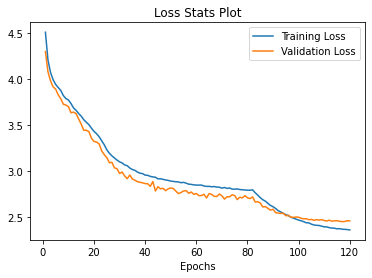

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy: 49.1%


In [11]:
from tqdm.notebook import tqdm

training_losses = []
val_losses = []

for ep in range(EPOCHS):
    
    epoch_loss = 0
    val_loss = 0
    model.train()
    for ims, labs in tqdm(loaders['train']):
        opt.zero_grad(set_to_none=True)
        with autocast():
            out = model(ims)
            loss = loss_fn(out, labs)
            epoch_loss += loss.item()
            
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
    scheduler.step()
    #print(scheduler.get_last_lr(), ep)
    
    model.eval()
    with torch.no_grad():
        for ims, labs in tqdm(loaders['test']):
            with autocast():
                out = model(ims)
                loss = loss_fn(out, labs)
                val_loss += loss.item()
            
    val_loss = val_loss / len(loaders['test'])
    #scheduler.step()
    epoch_loss = epoch_loss/ len(loaders['train'])
    
    training_losses.append(epoch_loss)
    val_losses.append(val_loss)
    print( f'Epoch: {ep}  Training loss: {epoch_loss} Val loss: {val_loss}')

plot_train_val(training_losses, val_losses)

model.eval()
with ch.no_grad():
    total_correct, total_num = 0., 0.
    for ims, labs in tqdm(loaders['test']):
        with autocast():
            out = model(ims)   #(model(ims) + model(ch.fliplr(ims))) / 2. # Test-time augmentation
            total_correct += out.argmax(1).eq(labs).sum().cpu().item()
            total_num += ims.shape[0]

    print(f'Accuracy: {total_correct / total_num * 100:.1f}%')

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 120  Training loss: 2.3694026188972668 Val loss: 2.4588202404070505


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 121  Training loss: 2.364050877399934 Val loss: 2.450604010231887


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 122  Training loss: 2.3619591040489003 Val loss: 2.4502566554878333


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 123  Training loss: 2.3653049499560623 Val loss: 2.4561505136610586


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 124  Training loss: 2.357081436499571 Val loss: 2.4547197275523898


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 125  Training loss: 2.355543035115951 Val loss: 2.4540396943877014


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 126  Training loss: 2.3656893907449184 Val loss: 2.4584704501719417


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 127  Training loss: 2.358182922999064 Val loss: 2.452898973151098


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 128  Training loss: 2.355480742454529 Val loss: 2.452374742000918


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 129  Training loss: 2.3598993209692147 Val loss: 2.4542422113539297


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 130  Training loss: 2.357244198750227 Val loss: 2.4540536614912973


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 131  Training loss: 2.354052288715656 Val loss: 2.4579408681845365


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 132  Training loss: 2.3480936985749463 Val loss: 2.4497851933105084


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 133  Training loss: 2.3509870767593384 Val loss: 2.4561169147491455


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 134  Training loss: 2.3508295346529056 Val loss: 2.4585243418246887


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 135  Training loss: 2.357253045302171 Val loss: 2.454066994823987


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 136  Training loss: 2.350542165682866 Val loss: 2.454704966726182


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 137  Training loss: 2.3528822232515383 Val loss: 2.449321722682518


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 138  Training loss: 2.348117896226736 Val loss: 2.4599602614776996


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 139  Training loss: 2.350778299722916 Val loss: 2.4575211398209196


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 140  Training loss: 2.3504528027314406 Val loss: 2.4622093212755423


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 141  Training loss: 2.3518945125433115 Val loss: 2.451728672920903


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 142  Training loss: 2.3575497425519503 Val loss: 2.456617859345448


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 143  Training loss: 2.354515373401153 Val loss: 2.4592050449757634


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 144  Training loss: 2.3486362542861547 Val loss: 2.4558696777005737


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 145  Training loss: 2.345024588780525 Val loss: 2.4530802708637864


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 146  Training loss: 2.3475503927622086 Val loss: 2.4566038922418523


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 147  Training loss: 2.3461536774268517 Val loss: 2.4601295205611216


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 148  Training loss: 2.34645765316792 Val loss: 2.444430914106248


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 149  Training loss: 2.346198638280233 Val loss: 2.447327496130255


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 150  Training loss: 2.3470738025812 Val loss: 2.4535661558561688


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 151  Training loss: 2.3508761283678887 Val loss: 2.4543642363970792


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 152  Training loss: 2.340037797047542 Val loss: 2.4535719261893743


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 153  Training loss: 2.3462939280730026 Val loss: 2.4570979468430143


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 154  Training loss: 2.3501095875715596 Val loss: 2.4603484733195247


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 155  Training loss: 2.347985981672238 Val loss: 2.458601224271557


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 156  Training loss: 2.347152959994781 Val loss: 2.4511332330824454


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 157  Training loss: 2.3531256443414934 Val loss: 2.453457569774193


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 158  Training loss: 2.351054727114164 Val loss: 2.457447984550573


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 159  Training loss: 2.350359239945045 Val loss: 2.4554940748818312


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 160  Training loss: 2.3456144387905415 Val loss: 2.4555392597295063


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 161  Training loss: 2.349769303126213 Val loss: 2.452898170374617


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 162  Training loss: 2.3435766727496414 Val loss: 2.451980937885333


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 163  Training loss: 2.3491053483425044 Val loss: 2.459789834445036


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 164  Training loss: 2.3480459983532245 Val loss: 2.462192849267887


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 165  Training loss: 2.349782917438409 Val loss: 2.4543735799910147


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 166  Training loss: 2.344817776557727 Val loss: 2.457739495023896


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 167  Training loss: 2.345170121315198 Val loss: 2.454157310196116


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 168  Training loss: 2.3478344348760753 Val loss: 2.4553668710249887


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 169  Training loss: 2.351852161456377 Val loss: 2.453929170777526


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 170  Training loss: 2.348637613883385 Val loss: 2.4600301875343806


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 171  Training loss: 2.345863861915393 Val loss: 2.456011898909943


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 172  Training loss: 2.3521439252755583 Val loss: 2.4476713455176053


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 173  Training loss: 2.347070172505501 Val loss: 2.4541398181190974


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 174  Training loss: 2.3479142347971598 Val loss: 2.4521625675732577


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 175  Training loss: 2.34598800769219 Val loss: 2.4534464878372


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 176  Training loss: 2.343696895623818 Val loss: 2.4524044628384747


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 177  Training loss: 2.3477404044224666 Val loss: 2.4551852232293236


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 178  Training loss: 2.3479170157359195 Val loss: 2.455684444572352


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 179  Training loss: 2.3446754749004657 Val loss: 2.4556495056876653


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 180  Training loss: 2.3509675007600053 Val loss: 2.4476009833661814


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 181  Training loss: 2.3478017923159475 Val loss: 2.4562846286387385


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 182  Training loss: 2.3528897444407146 Val loss: 2.4558683528175838


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 183  Training loss: 2.347364101043114 Val loss: 2.4591110205348534


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 184  Training loss: 2.349042012752631 Val loss: 2.453569916230214


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 185  Training loss: 2.3466962435306646 Val loss: 2.4503758798671673


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 186  Training loss: 2.3468410259638075 Val loss: 2.4518432828444467


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 187  Training loss: 2.3503607927224577 Val loss: 2.45039016989213


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 188  Training loss: 2.3495908529330523 Val loss: 2.4509105682373047


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 189  Training loss: 2.3408130902510424 Val loss: 2.4514212879953505


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 190  Training loss: 2.3495313748335227 Val loss: 2.4554753001732164


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 191  Training loss: 2.344950057298709 Val loss: 2.462461033953896


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 192  Training loss: 2.357192027263152 Val loss: 2.454902579512777


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 193  Training loss: 2.3479398599037755 Val loss: 2.4564748685571214


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 194  Training loss: 2.3442466512704505 Val loss: 2.4617526108705543


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 195  Training loss: 2.3478670762135434 Val loss: 2.4542676889443698


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 196  Training loss: 2.3442788729300865 Val loss: 2.4549759943274


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 197  Training loss: 2.350440318767841 Val loss: 2.4546149410778964


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 198  Training loss: 2.351826349282876 Val loss: 2.448839920985548


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 199  Training loss: 2.351368502470163 Val loss: 2.456098312064062


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 200  Training loss: 2.351207657960745 Val loss: 2.463224951224991


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 201  Training loss: 2.345893696638254 Val loss: 2.458911307250397


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 202  Training loss: 2.3418020700797055 Val loss: 2.455980216400533


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 203  Training loss: 2.3462897802010563 Val loss: 2.449724061579644


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 204  Training loss: 2.3497457754917632 Val loss: 2.4548769268808486


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 205  Training loss: 2.347929054651505 Val loss: 2.450942012328136


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 206  Training loss: 2.3513484221238357 Val loss: 2.4585177566431744


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 207  Training loss: 2.3469807471984474 Val loss: 2.461810631088064


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 208  Training loss: 2.3507104464066333 Val loss: 2.4502886760083933


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 209  Training loss: 2.34881027784103 Val loss: 2.4499468501610093


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 210  Training loss: 2.3459795102094994 Val loss: 2.4539259898511667


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 211  Training loss: 2.3454290338051624 Val loss: 2.4549105680441556


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 212  Training loss: 2.346010986963908 Val loss: 2.461066233960888


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 213  Training loss: 2.3529621252646815 Val loss: 2.4554527801803396


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 214  Training loss: 2.3470954888906235 Val loss: 2.4541222173956374


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 215  Training loss: 2.3495437316405465 Val loss: 2.457119323030303


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 216  Training loss: 2.347968838765071 Val loss: 2.4539906495734107


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 217  Training loss: 2.3510948193378938 Val loss: 2.448964613902418


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 218  Training loss: 2.349844801120269 Val loss: 2.458343883103962


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 219  Training loss: 2.3458949009577434 Val loss: 2.4530358374873296


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 220  Training loss: 2.3489988412612526 Val loss: 2.4547607959071294


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 221  Training loss: 2.3504351371373886 Val loss: 2.4623018638997136


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 222  Training loss: 2.3473186743565093 Val loss: 2.4555731061138686


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 223  Training loss: 2.3484502706772243 Val loss: 2.4528582458254657


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 224  Training loss: 2.345797635958745 Val loss: 2.4515207930456233


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 225  Training loss: 2.3533969200574436 Val loss: 2.4529607024373887


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 226  Training loss: 2.34694924782484 Val loss: 2.4535161271879944


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 227  Training loss: 2.348275758058597 Val loss: 2.453671630424789


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 228  Training loss: 2.346596626746349 Val loss: 2.4512150710142113


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 229  Training loss: 2.3512333545929347 Val loss: 2.45062777664088


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 230  Training loss: 2.3430137524238 Val loss: 2.453645591494403


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 231  Training loss: 2.3460362978470632 Val loss: 2.4512439407879794


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 232  Training loss: 2.3481173753738402 Val loss: 2.447096399114102


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 233  Training loss: 2.343859505042052 Val loss: 2.4508100974408884


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 234  Training loss: 2.3463097101602797 Val loss: 2.451114521750921


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 235  Training loss: 2.345048622595958 Val loss: 2.449458876742592


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 236  Training loss: 2.34175629004454 Val loss: 2.4464386626134944


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 237  Training loss: 2.346775890619327 Val loss: 2.4525016018106967


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 238  Training loss: 2.3463438339722464 Val loss: 2.4482850213594074


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 239  Training loss: 2.349889931923304 Val loss: 2.451540919798839


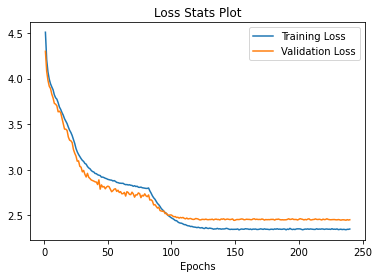

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy: 49.3%


In [12]:
for ep in range(120, 240, 1):
    
    epoch_loss = 0
    val_loss = 0
    model.train()
    for ims, labs in tqdm(loaders['train']):
        opt.zero_grad(set_to_none=True)
        with autocast():
            out = model(ims)
            loss = loss_fn(out, labs)
            epoch_loss += loss.item()
            
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
    scheduler.step()
    #print(scheduler.get_last_lr(), ep)
    
    model.eval()
    with torch.no_grad():
        for ims, labs in tqdm(loaders['test']):
            with autocast():
                out = model(ims)
                loss = loss_fn(out, labs)
                val_loss += loss.item()
            
    val_loss = val_loss / len(loaders['test'])
    #scheduler.step()
    epoch_loss = epoch_loss/ len(loaders['train'])
    
    training_losses.append(epoch_loss)
    val_losses.append(val_loss)
    print( f'Epoch: {ep}  Training loss: {epoch_loss} Val loss: {val_loss}')

plot_train_val(training_losses, val_losses)

model.eval()
with ch.no_grad():
    total_correct, total_num = 0., 0.
    for ims, labs in tqdm(loaders['test']):
        with autocast():
            out = model(ims)   #(model(ims) + model(ch.fliplr(ims))) / 2. # Test-time augmentation
            total_correct += out.argmax(1).eq(labs).sum().cpu().item()
            total_num += ims.shape[0]

    print(f'Accuracy: {total_correct / total_num * 100:.1f}%')

  0%|          | 0/390 [00:00<?, ?it/s]

[0.000276] 0
Epoch: 0  Training loss: 3.9614593780957734


  0%|          | 0/390 [00:00<?, ?it/s]

[0.000282] 1
Epoch: 1  Training loss: 3.5266962454869195


  0%|          | 0/390 [00:00<?, ?it/s]

[0.000288] 2
Epoch: 2  Training loss: 3.332643804794703


  0%|          | 0/390 [00:00<?, ?it/s]

[0.000294] 3
Epoch: 3  Training loss: 3.1916346109830416


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 4
Epoch: 4  Training loss: 3.074674238302769


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 5
Epoch: 5  Training loss: 2.9610731057631665


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 6
Epoch: 6  Training loss: 2.8698073888436344


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 7
Epoch: 7  Training loss: 2.769236815892733


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 8
Epoch: 8  Training loss: 2.6762797826375717


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 9
Epoch: 9  Training loss: 2.6079905888973136


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 10
Epoch: 10  Training loss: 2.5271146884331337


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 11
Epoch: 11  Training loss: 2.451770165639046


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 12
Epoch: 12  Training loss: 2.3945135837946183


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 13
Epoch: 13  Training loss: 2.3253841363466705


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 14
Epoch: 14  Training loss: 2.262971564439627


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 15
Epoch: 15  Training loss: 2.201545516344217


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 16
Epoch: 16  Training loss: 2.151099376189403


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 17
Epoch: 17  Training loss: 2.090836615745838


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 18
Epoch: 18  Training loss: 2.0427825001569895


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 19
Epoch: 19  Training loss: 1.9989203615066333


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 20
Epoch: 20  Training loss: 1.9433162035086216


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 21
Epoch: 21  Training loss: 1.910373852497492


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 22
Epoch: 22  Training loss: 1.8620219542429997


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 23
Epoch: 23  Training loss: 1.819246230369959


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 24
Epoch: 24  Training loss: 1.7794502710684752


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 25
Epoch: 25  Training loss: 1.7347868616764361


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 26
Epoch: 26  Training loss: 1.7024503231048584


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 27
Epoch: 27  Training loss: 1.6560141856853778


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 28
Epoch: 28  Training loss: 1.6231397396478897


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 29
Epoch: 29  Training loss: 1.5967641332210638


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 30
Epoch: 30  Training loss: 1.5536512863941683


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 31
Epoch: 31  Training loss: 1.5240152007494217


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 32
Epoch: 32  Training loss: 1.489646954719837


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 33
Epoch: 33  Training loss: 1.4675601173669863


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 34
Epoch: 34  Training loss: 1.4386343613649026


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 35
Epoch: 35  Training loss: 1.4123796025911968


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 36
Epoch: 36  Training loss: 1.3839906930923462


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 37
Epoch: 37  Training loss: 1.3611099405166431


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 38
Epoch: 38  Training loss: 1.340306796783056


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 39
Epoch: 39  Training loss: 1.3199468123607145


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 40
Epoch: 40  Training loss: 1.3055759121210146


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 41
Epoch: 41  Training loss: 1.2884521359052414


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 42
Epoch: 42  Training loss: 1.262531842940893


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 43
Epoch: 43  Training loss: 1.2567546816972586


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 44
Epoch: 44  Training loss: 1.2440518623743302


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 45
Epoch: 45  Training loss: 1.227505677479964


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 46
Epoch: 46  Training loss: 1.2177674296574714


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 47
Epoch: 47  Training loss: 1.2096504028026873


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 48
Epoch: 48  Training loss: 1.1946758123544545


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 49
Epoch: 49  Training loss: 1.1901198955682608


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 50
Epoch: 50  Training loss: 1.1746102293332419


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 51
Epoch: 51  Training loss: 1.1713742922513912


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 52
Epoch: 52  Training loss: 1.1615374555954567


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 53
Epoch: 53  Training loss: 1.1649364700684182


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 54
Epoch: 54  Training loss: 1.1456921488810807


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 55
Epoch: 55  Training loss: 1.1360607303105867


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 56
Epoch: 56  Training loss: 1.1366502835200383


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 57
Epoch: 57  Training loss: 1.1348960041999816


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 58
Epoch: 58  Training loss: 1.1258733776899486


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 59
Epoch: 59  Training loss: 1.1213222308036608


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 60
Epoch: 60  Training loss: 1.1150092109655723


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 61
Epoch: 61  Training loss: 1.109750697704462


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 62
Epoch: 62  Training loss: 1.1045862011420422


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 63
Epoch: 63  Training loss: 1.1009372992393298


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 64
Epoch: 64  Training loss: 1.0981123846310836


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 65
Epoch: 65  Training loss: 1.089069850016863


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 66
Epoch: 66  Training loss: 1.0890906118429624


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 67
Epoch: 67  Training loss: 1.085154204338025


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 68
Epoch: 68  Training loss: 1.0794292494272575


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 69
Epoch: 69  Training loss: 1.073304613584127


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 70
Epoch: 70  Training loss: 1.072585738163728


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 71
Epoch: 71  Training loss: 1.0694864465640141


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 72
Epoch: 72  Training loss: 1.0647312723673308


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 73
Epoch: 73  Training loss: 1.0613028607307335


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 74
Epoch: 74  Training loss: 1.060740214280593


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 75
Epoch: 75  Training loss: 1.056559063685246


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 76
Epoch: 76  Training loss: 1.0582268384786753


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 77
Epoch: 77  Training loss: 1.057533619954036


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 78
Epoch: 78  Training loss: 1.054429175456365


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 79
Epoch: 79  Training loss: 1.0477940447819538


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 80
Epoch: 80  Training loss: 1.0426339768446409


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 81
Epoch: 81  Training loss: 1.0465371298484314


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 82
Epoch: 82  Training loss: 1.0384079908713317


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 83
Epoch: 83  Training loss: 1.0408439686665167


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 84
Epoch: 84  Training loss: 1.0364521666979178


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 85
Epoch: 85  Training loss: 1.0327133981081156


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 86
Epoch: 86  Training loss: 1.0252984941005707


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 87
Epoch: 87  Training loss: 1.0311508325430063


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 88
Epoch: 88  Training loss: 1.0299528948771648


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 89
Epoch: 89  Training loss: 1.0255929751273913


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 90
Epoch: 90  Training loss: 1.0255510602241908


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 91
Epoch: 91  Training loss: 1.0212014092848851


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 92
Epoch: 92  Training loss: 1.0279225797225267


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 93
Epoch: 93  Training loss: 1.0208613333029626


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 94
Epoch: 94  Training loss: 1.0180698194564917


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 95
Epoch: 95  Training loss: 1.0152056834636591


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 96
Epoch: 96  Training loss: 1.00789453234428


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 97
Epoch: 97  Training loss: 1.0111239943748866


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 98
Epoch: 98  Training loss: 1.0066064901840992


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 99
Epoch: 99  Training loss: 1.0125039757826388


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 100
Epoch: 100  Training loss: 1.0056952141798459


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 101
Epoch: 101  Training loss: 1.0068686619783058


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 102
Epoch: 102  Training loss: 1.003816475929358


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 103
Epoch: 103  Training loss: 1.0027727153056707


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 104
Epoch: 104  Training loss: 1.0021062112771548


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 105
Epoch: 105  Training loss: 0.999195391856707


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 106
Epoch: 106  Training loss: 0.9956752881025657


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 107
Epoch: 107  Training loss: 1.000591289691436


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 108
Epoch: 108  Training loss: 0.9960639388133318


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 109
Epoch: 109  Training loss: 0.9882802619383886


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 110
Epoch: 110  Training loss: 0.9914340074245747


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 111
Epoch: 111  Training loss: 0.9973123504565312


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 112
Epoch: 112  Training loss: 0.9888726408664997


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 113
Epoch: 113  Training loss: 0.9903376203316908


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 114
Epoch: 114  Training loss: 0.9899932717665648


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 115
Epoch: 115  Training loss: 0.9882060072360894


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 116
Epoch: 116  Training loss: 0.9857525645158229


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 117
Epoch: 117  Training loss: 0.980572919967847


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 118
Epoch: 118  Training loss: 0.9800615717203189


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003] 119
Epoch: 119  Training loss: 0.983333885211211


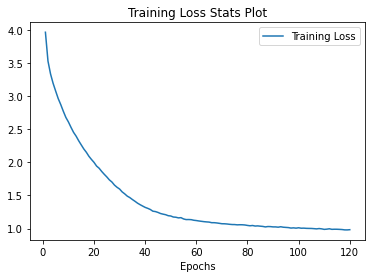

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy: 59.4%


In [11]:
from tqdm.notebook import tqdm

training_losses = []

for ep in range(EPOCHS):
    
    epoch_loss = 0
    
    for ims, labs in tqdm(loaders['train']):
        opt.zero_grad(set_to_none=True)
        with autocast():
            out = model(ims)
            loss = loss_fn(out, labs)
            epoch_loss += loss.item()
            
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
    scheduler.step()
    print(scheduler.get_last_lr(), ep)
    
    epoch_loss = epoch_loss/ len(loaders['train'])
    training_losses.append(epoch_loss)
    print( f'Epoch: {ep}  Training loss: {epoch_loss}')

plot_stats(training_losses)

model.eval()
with ch.no_grad():
    total_correct, total_num = 0., 0.
    for ims, labs in tqdm(loaders['test']):
        with autocast():
            out = model(ims)   #(model(ims) + model(ch.fliplr(ims))) / 2. # Test-time augmentation
            total_correct += out.argmax(1).eq(labs).sum().cpu().item()
            total_num += ims.shape[0]

    print(f'Accuracy: {total_correct / total_num * 100:.1f}%')

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0  Training loss: 1.3257861345242232 Val loss: 2.2362584916851187


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1  Training loss: 1.2908078046945426 Val loss: 2.2529843049713327


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2  Training loss: 1.280867726374895 Val loss: 2.250997668580164


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3  Training loss: 1.2794593425897451 Val loss: 2.2486749510221844


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4  Training loss: 1.285330558434511 Val loss: 2.2727028569088707


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5  Training loss: 1.2734798495586102 Val loss: 2.2356805212890047


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6  Training loss: 1.272723284134498 Val loss: 2.269284741787971


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7  Training loss: 1.2694445255475166 Val loss: 2.2381304819372634


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8  Training loss: 1.2681518863408994 Val loss: 2.256829426258425


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9  Training loss: 1.2618744125733008 Val loss: 2.324833371971227


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10  Training loss: 1.2656860654170696 Val loss: 2.2289034158368652


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11  Training loss: 1.2522287322924688 Val loss: 2.236433579951902


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12  Training loss: 1.2578594586788079 Val loss: 2.2570867613901067


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13  Training loss: 1.2518415625278767 Val loss: 2.2550052132787584


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14  Training loss: 1.245189990141453 Val loss: 2.273263931274414


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15  Training loss: 1.2560570129981408 Val loss: 2.2800302580942082


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16  Training loss: 1.2439462169622764 Val loss: 2.227589626855488


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17  Training loss: 1.2420574897374863 Val loss: 2.260368842112867


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18  Training loss: 1.2415427758143498 Val loss: 2.264278457134585


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19  Training loss: 1.2424416691828997 Val loss: 2.245534456228908


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 20  Training loss: 1.2382414056704594 Val loss: 2.263976761057407


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 21  Training loss: 1.235280868028983 Val loss: 2.2673493427566336


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 22  Training loss: 1.234792545514229 Val loss: 2.2590544193605835


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 23  Training loss: 1.0355848257358258 Val loss: 2.0969662077819247


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 24  Training loss: 0.9683914024096268 Val loss: 2.1035975655422936


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 25  Training loss: 0.9486314920278696 Val loss: 2.1064745972428143


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 26  Training loss: 0.9387274491481292 Val loss: 2.1047774447670466


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 27  Training loss: 0.9334343499098069 Val loss: 2.104820426506332


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 28  Training loss: 0.9315089027086894 Val loss: 2.098214389402655


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 29  Training loss: 0.9291060945926568 Val loss: 2.118717623662345


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 30  Training loss: 0.8989211828280718 Val loss: 2.079896386665634


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 31  Training loss: 0.8885407184943175 Val loss: 2.077132968962947


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 32  Training loss: 0.8836965174247057 Val loss: 2.083235372470904


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 33  Training loss: 0.8799852068607624 Val loss: 2.079039446915252


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 34  Training loss: 0.8768953184286753 Val loss: 2.080920030799093


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 35  Training loss: 0.8752296800796803 Val loss: 2.074068848090836


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 36  Training loss: 0.8733891322062566 Val loss: 2.0793350391750094


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 37  Training loss: 0.8706426985752889 Val loss: 2.0870590013793753


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 38  Training loss: 0.8708934071736458 Val loss: 2.081945508341246


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 39  Training loss: 0.8711322058469821 Val loss: 2.1014938339402405


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 40  Training loss: 0.868732132208653 Val loss: 2.101573746415633


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 41  Training loss: 0.8688034040805621 Val loss: 2.0984261911126634


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 42  Training loss: 0.860055772616313 Val loss: 2.0747010074084318


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 43  Training loss: 0.8577319657191252 Val loss: 2.073365110385267


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 44  Training loss: 0.8551177599491218 Val loss: 2.074441190007367


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 45  Training loss: 0.853493989430941 Val loss: 2.0788051478470426


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 46  Training loss: 0.85434273038155 Val loss: 2.076776104637339


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 47  Training loss: 0.8531411154147907 Val loss: 2.0775716908370394


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 48  Training loss: 0.8520416215444222 Val loss: 2.078624683090403


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 49  Training loss: 0.8512459498185377 Val loss: 2.0795220513887043


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 50  Training loss: 0.850017223908351 Val loss: 2.078092246115962


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 51  Training loss: 0.8477891779862917 Val loss: 2.075902338269391


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 52  Training loss: 0.8488742308738905 Val loss: 2.069984235341036


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 53  Training loss: 0.8471739770510258 Val loss: 2.0829862703250934


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 54  Training loss: 0.8480365812778473 Val loss: 2.0702787396274034


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 55  Training loss: 0.8484606336324643 Val loss: 2.070254055759575


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 56  Training loss: 0.8477968267905407 Val loss: 2.0753556459764892


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 57  Training loss: 0.84663941799066 Val loss: 2.067759563651266


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 58  Training loss: 0.8475692097957318 Val loss: 2.077879803090156


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 59  Training loss: 0.8469916190856542 Val loss: 2.0708869529675833


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 60  Training loss: 0.8464774685028272 Val loss: 2.0741149594512165


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 61  Training loss: 0.8459274542637361 Val loss: 2.075861259351803


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 62  Training loss: 0.8462172957567068 Val loss: 2.070756694938563


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 63  Training loss: 0.8462355963694743 Val loss: 2.072189800346954


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 64  Training loss: 0.8454017269305694 Val loss: 2.0765181025372277


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 65  Training loss: 0.8454630867028847 Val loss: 2.0773092613944524


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 66  Training loss: 0.8462705867412763 Val loss: 2.070551820948154


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 67  Training loss: 0.8452167003582686 Val loss: 2.075537492957296


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 68  Training loss: 0.8435220215565119 Val loss: 2.080446893655801


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 69  Training loss: 0.8446186475264721 Val loss: 2.077228085904182


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 70  Training loss: 0.8442938445470272 Val loss: 2.0792783181878587


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 71  Training loss: 0.844782171646754 Val loss: 2.076795965810365


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 72  Training loss: 0.8444869865209629 Val loss: 2.072617444810988


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 73  Training loss: 0.8439772772483337 Val loss: 2.0754708519464806


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 74  Training loss: 0.8436716960026668 Val loss: 2.0763950453528874


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 75  Training loss: 0.8448146980542403 Val loss: 2.0759094334855863


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 76  Training loss: 0.8434726196985979 Val loss: 2.083087972447842


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 77  Training loss: 0.8444703517816006 Val loss: 2.076353187802472


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 78  Training loss: 0.8447242558002472 Val loss: 2.0665535262868375


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 79  Training loss: 0.8443854159269577 Val loss: 2.0779379636426514


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 80  Training loss: 0.8443653085292914 Val loss: 2.079157198531718


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 81  Training loss: 0.8434741833271124 Val loss: 2.072754610942889


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 82  Training loss: 0.8441220755760487 Val loss: 2.083235212519199


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 83  Training loss: 0.8445623005047823 Val loss: 2.070201719863505


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 84  Training loss: 0.8441910447218479 Val loss: 2.0807629793505127


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 85  Training loss: 0.8435677057657487 Val loss: 2.0833650419983685


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 86  Training loss: 0.8444740851720174 Val loss: 2.074962664254104


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 87  Training loss: 0.8449412862459819 Val loss: 2.0858919197999977


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 88  Training loss: 0.8440091313459934 Val loss: 2.0796527892728394


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 89  Training loss: 0.8446328653739049 Val loss: 2.079225662388379


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 90  Training loss: 0.8445477311427777 Val loss: 2.074730426450319


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 91  Training loss: 0.8444265698775267 Val loss: 2.067854102653793


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 92  Training loss: 0.8451824941696264 Val loss: 2.0757269451889813


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 93  Training loss: 0.8442867821607835 Val loss: 2.068189444421213


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 94  Training loss: 0.8445731716278272 Val loss: 2.0794649757916415


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 95  Training loss: 0.8436959298757406 Val loss: 2.0760343648210355


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 96  Training loss: 0.8440294342163281 Val loss: 2.068816598457626


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 97  Training loss: 0.8445847324835949 Val loss: 2.0803334275378456


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 98  Training loss: 0.8438444200234535 Val loss: 2.0695977045010916


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 99  Training loss: 0.8450800369947384 Val loss: 2.0789363610593576


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 100  Training loss: 0.8447356500686743 Val loss: 2.0754113997085186


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 101  Training loss: 0.8448200941085815 Val loss: 2.069912512091142


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 102  Training loss: 0.8434160452622633 Val loss: 2.0752924922146376


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 103  Training loss: 0.843787016471227 Val loss: 2.075202013872847


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 104  Training loss: 0.8437942304672339 Val loss: 2.0822171093542363


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 105  Training loss: 0.8446838083939675 Val loss: 2.074608624735965


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 106  Training loss: 0.8439794641274673 Val loss: 2.0754383259181735


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 107  Training loss: 0.8441334933806688 Val loss: 2.0754516396341445


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 108  Training loss: 0.8440849197216523 Val loss: 2.072008967399597


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 109  Training loss: 0.8448244177378141 Val loss: 2.0789981944651545


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 110  Training loss: 0.8454799656684582 Val loss: 2.0673510515237155


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 111  Training loss: 0.844359793418493 Val loss: 2.0763253773315045


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 112  Training loss: 0.8451515488135509 Val loss: 2.0729638866231412


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 113  Training loss: 0.8443508077890445 Val loss: 2.082194750822043


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 114  Training loss: 0.845226872425813 Val loss: 2.0765956353537645


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 115  Training loss: 0.8438847974324838 Val loss: 2.0792151342464398


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 116  Training loss: 0.8443083518590683 Val loss: 2.07212788243837


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 117  Training loss: 0.8437638554817591 Val loss: 2.077194634872147


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 118  Training loss: 0.844236755829591 Val loss: 2.077939896643916


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 119  Training loss: 0.8434711360014402 Val loss: 2.074708801281603


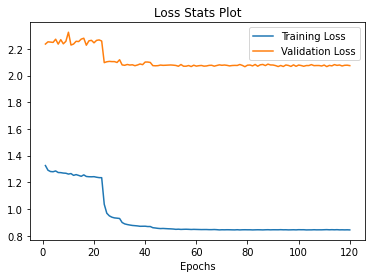

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy: 63.9%


In [27]:
from tqdm.notebook import tqdm

training_losses = []
val_losses = []

for ep in range(EPOCHS):
    
    epoch_loss = 0
    val_loss = 0
    model.train()
    for ims, labs in tqdm(loaders['train']):
        opt.zero_grad(set_to_none=True)
        with autocast():
            out = model(ims)
            loss = loss_fn(out, labs)
            epoch_loss += loss.item()
            
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
   
    #print(scheduler.get_last_lr(), ep)
    
    model.eval()
    with torch.no_grad():
        for ims, labs in tqdm(loaders['test']):
            with autocast():
                out = model(ims)
                loss = loss_fn(out, labs)
                val_loss += loss.item()
    
    val_loss = val_loss / len(loaders['test'])
    scheduler.step(val_loss)
    
    epoch_loss = epoch_loss/ len(loaders['train'])
    
    training_losses.append(epoch_loss)
    val_losses.append(val_loss)
    print( f'Epoch: {ep}  Training loss: {epoch_loss} Val loss: {val_loss}')

plot_train_val(training_losses, val_losses)

model.eval()
with ch.no_grad():
    total_correct, total_num = 0., 0.
    for ims, labs in tqdm(loaders['test']):
        with autocast():
            out = model(ims)   #(model(ims) + model(ch.fliplr(ims))) / 2. # Test-time augmentation
            total_correct += out.argmax(1).eq(labs).sum().cpu().item()
            total_num += ims.shape[0]

    print(f'Accuracy: {total_correct / total_num * 100:.1f}%')

In [29]:
import gc
del model
gc.collect()

0

  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 0


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0  Training loss: 4.113199774424235 Val loss: 3.8346818670441833


/home/gordon/anaconda3/envs/ffcv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/390 [00:00<?, ?it/s]

[0.000821442394838261] 1


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1  Training loss: 3.8337688678350204 Val loss: 3.6735040900073472


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008282616875840694] 2


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2  Training loss: 3.727500625145741 Val loss: 3.608856831924825


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008310127378685925] 3


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3  Training loss: 3.6484411074565006 Val loss: 3.543334306040897


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008338103590806334] 4


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4  Training loss: 3.588288373213548 Val loss: 3.4882347191436383


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008361702399355811] 5


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5  Training loss: 3.533532500267029 Val loss: 3.412390669689903


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008394295212911801] 6


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6  Training loss: 3.486357083076086 Val loss: 3.3882760850689078


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008404684679192224] 7


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7  Training loss: 3.4430537028190416 Val loss: 3.3044905028765714


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008440882703223337] 8


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8  Training loss: 3.388187831487411 Val loss: 3.26696808428704


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008457144078839236] 9


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9  Training loss: 3.3443387587865194 Val loss: 3.2102587192873413


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008481780118815835] 10


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10  Training loss: 3.3052845111260045 Val loss: 3.1550765701487093


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008505821587115107] 11


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11  Training loss: 3.265031397037017 Val loss: 3.136534778377678


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008513915063431216] 12


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12  Training loss: 3.2180202612510094 Val loss: 3.1146133036553105


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008523493703670969] 13


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13  Training loss: 3.1863207291334104 Val loss: 3.096300448043437


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008531503810297289] 14


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14  Training loss: 3.149444299477797 Val loss: 3.032250896284852


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008559578558435458] 15


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15  Training loss: 3.110667907886016 Val loss: 3.0120519565630564


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008568451478064504] 16


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16  Training loss: 3.073825062238253 Val loss: 2.9603716632987878


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008591195311010477] 17


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17  Training loss: 3.0421479396331006 Val loss: 2.915288149556027


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008611085283768931] 18


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18  Training loss: 3.011362284880418 Val loss: 2.8965957738176176


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008619345495924861] 19


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19  Training loss: 2.972330503586011 Val loss: 2.9023058354100093


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008616821363841664] 20


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 20  Training loss: 2.9494187000470284 Val loss: 2.843073437485514


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008643041014841674] 21


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 21  Training loss: 2.917277028010442 Val loss: 2.821813426440275


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008652471357482319] 22


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 22  Training loss: 2.8819797155184625 Val loss: 2.8120400452915626


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008656810005933632] 23


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 23  Training loss: 2.856300478715163 Val loss: 2.7533243970025945


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008682921185423639] 24


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 24  Training loss: 2.838917492597531 Val loss: 2.761296869833258


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008679371166205984] 25


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 25  Training loss: 2.8058242852871236 Val loss: 2.7447383524496343


  0%|          | 0/390 [00:00<?, ?it/s]

[0.000868674604263134] 26


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 26  Training loss: 2.7839358610984606 Val loss: 2.7081874624083313


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008703047365516113] 27


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 27  Training loss: 2.7655581700496183 Val loss: 2.710615963875493


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008701963330622847] 28


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 28  Training loss: 2.7495806272213277 Val loss: 2.7098722427706177


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008702295298630199] 29


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 29  Training loss: 2.7264954768694363 Val loss: 2.673115126694305


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008718718027068938] 30


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 30  Training loss: 2.71166854149256 Val loss: 2.6932760944849328


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008709706465301699] 31


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 31  Training loss: 2.6893816666725354 Val loss: 2.706478665146647


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008703810219665382] 32


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 32  Training loss: 2.681568548618219 Val loss: 2.6448508968836144


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008731367290339782] 33


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 33  Training loss: 2.6617162135931163 Val loss: 2.63072228129906


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008737697233879591] 34


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 34  Training loss: 2.6455354256507677 Val loss: 2.624323135689844


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008740565707462199] 35


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 35  Training loss: 2.638901819326939 Val loss: 2.6519302778606173


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008728197290166186] 36


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 36  Training loss: 2.622592702278724 Val loss: 2.62029048762744


  0%|          | 0/390 [00:00<?, ?it/s]

[0.000874237386128636] 37


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 37  Training loss: 2.6134256821412305 Val loss: 2.5956074980240835


  0%|          | 0/390 [00:00<?, ?it/s]

[0.000875344934445188] 38


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 38  Training loss: 2.602337703338036 Val loss: 2.5792513316190697


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008760796234279691] 39


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 39  Training loss: 2.5865089654922486 Val loss: 2.579952602145038


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008760481109940709] 40


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 40  Training loss: 2.576284189713307 Val loss: 2.56376963023898


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008767756011021495] 41


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 41  Training loss: 2.5742541912274484 Val loss: 2.5762271458589576


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008762155318346222] 42


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 42  Training loss: 2.5571930952561206 Val loss: 2.5592297391046452


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008769797960792207] 43


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 43  Training loss: 2.5389720421571 Val loss: 2.59198389174063


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008755076470438367] 44


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 44  Training loss: 2.5400727877250087 Val loss: 2.549633895294576


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008774115539233665] 45


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 45  Training loss: 2.525122825915997 Val loss: 2.547024153455903


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008775290140753369] 46


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 46  Training loss: 2.5131582578023273 Val loss: 2.586863209929647


  0%|          | 0/390 [00:00<?, ?it/s]

[0.000875737635142978] 47


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 47  Training loss: 2.5082633764315876 Val loss: 2.532932486715196


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008781635283645742] 48


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 48  Training loss: 2.495520488421122 Val loss: 2.5173900278308725


  0%|          | 0/390 [00:00<?, ?it/s]

[0.000878863900473837] 49


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 49  Training loss: 2.4863657664030026 Val loss: 2.586295263676704


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008757631473583048] 50


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 50  Training loss: 2.475769171347985 Val loss: 2.5251837923556946


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008785126291529013] 51


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 51  Training loss: 2.4671930117484853 Val loss: 2.542963251282897


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008777118198191067] 52


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 52  Training loss: 2.4582219667923755 Val loss: 2.5251487629323064


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008785142076434323] 53


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 53  Training loss: 2.4487947647388166 Val loss: 2.528375073324276


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008783688360352619] 54


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 54  Training loss: 2.4461979609269364 Val loss: 2.5153994288625596


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008789536409078908] 55


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 55  Training loss: 2.4306394760425274 Val loss: 2.5013497418995145


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008795872913003295] 56


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 56  Training loss: 2.4301332216996414 Val loss: 2.498515738716608


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008797151621169587] 57


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 57  Training loss: 2.419466427044991 Val loss: 2.5058037751837623


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008793863619462347] 58


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 58  Training loss: 2.415009880065918 Val loss: 2.5149043662638606


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008789759608052938] 59


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 59  Training loss: 2.4030954776666102 Val loss: 2.484493439710593


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008803481247708129] 60


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 60  Training loss: 2.391355698536604 Val loss: 2.5302091731300838


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008782862055984601] 61


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 61  Training loss: 2.387791822506831 Val loss: 2.5190471365481995


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008787892014779278] 62


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 62  Training loss: 2.380695849809891 Val loss: 2.498179991034013


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008797303123542051] 63


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 63  Training loss: 2.3708704416568462 Val loss: 2.5198050571393362


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008787550381185794] 64


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 64  Training loss: 2.361023420248276 Val loss: 2.500039414514469


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008796464112358031] 65


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 65  Training loss: 2.353496956825256 Val loss: 2.5008482450171363


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008796099175910145] 66


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 66  Training loss: 2.3536220813408875 Val loss: 2.5026284863677204


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008795296001678636] 67


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 67  Training loss: 2.3383585477486637 Val loss: 2.4808183169063134


  0%|          | 0/390 [00:00<?, ?it/s]

[0.000880514094095598] 68


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 68  Training loss: 2.3344875916456567 Val loss: 2.477661328979685


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008806566893228853] 69


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 69  Training loss: 2.33118009017064 Val loss: 2.4889897696579557


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008801451121071385] 70


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 70  Training loss: 2.323549449749482 Val loss: 2.4851153983345515


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008803200400828351] 71


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 71  Training loss: 2.318921212660961 Val loss: 2.4627058868166767


  0%|          | 0/390 [00:00<?, ?it/s]

[0.000881332512491778] 72


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 72  Training loss: 2.3056299857604197 Val loss: 2.4923002991495253


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008799956691464735] 73


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 73  Training loss: 2.3015381758029645 Val loss: 2.468086275873305


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008810893177733057] 74


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 74  Training loss: 2.297279387865311 Val loss: 2.4970720448071444


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008797803090349893] 75


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 75  Training loss: 2.2834929301188542 Val loss: 2.4725008222121225


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008808898294684961] 76


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 76  Training loss: 2.2838577542549525 Val loss: 2.5065602049042908


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008793522426175088] 77


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 77  Training loss: 2.274611540024097 Val loss: 2.4868355250056786


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008802423720237256] 78


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 78  Training loss: 2.261616441531059 Val loss: 2.5074287124826937


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008793130695656529] 79


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 79  Training loss: 2.260309304946508 Val loss: 2.493898286095148


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008799235423644194] 80


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 80  Training loss: 2.255552741197439 Val loss: 2.4816465407987183


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008804766885981238] 81


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 81  Training loss: 2.248566450828161 Val loss: 2.485296345964263


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008803118695182976] 82


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 82  Training loss: 2.2445083159666797 Val loss: 2.488214915311789


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008801800940220005] 83


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 83  Training loss: 2.2305961003670327 Val loss: 2.475712884830523


  0%|          | 0/390 [00:00<?, ?it/s]

[0.000880744708417162] 84


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 84  Training loss: 2.2324492417849027 Val loss: 2.4883767653115187


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008801727869559026] 85


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 85  Training loss: 2.2217760550670134 Val loss: 2.4855376225483568


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008803009749597017] 86


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 86  Training loss: 2.2150346169104944 Val loss: 2.483265979380547


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008804035536597848] 87


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 87  Training loss: 2.2102540450218395 Val loss: 2.4643214578869976


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008812594812881859] 88


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 88  Training loss: 2.2015818070142696 Val loss: 2.4734979822665832


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008808447751987341] 89


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 89  Training loss: 2.1936933324887202 Val loss: 2.4722217004510423


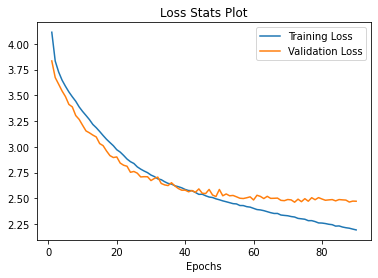

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy: 48.7%


In [10]:
from tqdm.notebook import tqdm

training_losses = []
val_losses = []

for ep in range(EPOCHS):
    
    epoch_loss = 0
    val_loss = 0
    model.train()
    for ims, labs in tqdm(loaders['train']):
        opt.zero_grad(set_to_none=True)
        with autocast():
            out = model(ims)
            loss = loss_fn(out, labs)
            epoch_loss += loss.item()
            
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
   
    print(scheduler.get_last_lr(), ep)
    
    model.eval()
    with torch.no_grad():
        for ims, labs in tqdm(loaders['test']):
            with autocast():
                out = model(ims)
                loss = loss_fn(out, labs)
                val_loss += loss.item()
    
    val_loss = val_loss / len(loaders['test'])
    scheduler.step(val_loss)
    
    epoch_loss = epoch_loss/ len(loaders['train'])
    
    training_losses.append(epoch_loss)
    val_losses.append(val_loss)
    print( f'Epoch: {ep}  Training loss: {epoch_loss} Val loss: {val_loss}')

plot_train_val(training_losses, val_losses)

model.eval()
with ch.no_grad():
    total_correct, total_num = 0., 0.
    for ims, labs in tqdm(loaders['test']):
        with autocast():
            out = model(ims)   #(model(ims) + model(ch.fliplr(ims))) / 2. # Test-time augmentation
            total_correct += out.argmax(1).eq(labs).sum().cpu().item()
            total_num += ims.shape[0]

    print(f'Accuracy: {total_correct / total_num * 100:.1f}%')

  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 0


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0  Training loss: 4.119850096947108 Val loss: 3.832126104379002


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 1


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1  Training loss: 3.8510997240359965 Val loss: 3.7090061797371394


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 2


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2  Training loss: 3.747949885099362 Val loss: 3.5945524414883385


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 3


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3  Training loss: 3.6681083960410876 Val loss: 3.530751346032831


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 4


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4  Training loss: 3.5921196576876517 Val loss: 3.4618317326412926


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 5


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5  Training loss: 3.534780669212341 Val loss: 3.3954812997504127


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 6


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6  Training loss: 3.4857290934293697 Val loss: 3.3520815432826176


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 7


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7  Training loss: 3.425067652188815 Val loss: 3.308952391902103


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 8


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8  Training loss: 3.368551625349583 Val loss: 3.256387677373765


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 9


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9  Training loss: 3.331201217113397 Val loss: 3.196621952177603


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 10


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10  Training loss: 3.2847195136241423 Val loss: 3.148096440713617


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 11


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11  Training loss: 3.249004115813818 Val loss: 3.119574984417686


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 12


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12  Training loss: 3.2104003325486796 Val loss: 3.1024290791040734


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 13


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13  Training loss: 3.167933306327233 Val loss: 3.0686008145537556


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 14


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14  Training loss: 3.1336117561046892 Val loss: 3.036961383457425


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 15


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15  Training loss: 3.0991489673272157 Val loss: 3.010798544823369


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 16


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16  Training loss: 3.066542008595589 Val loss: 2.935167237173153


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 17


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17  Training loss: 3.034517002105713 Val loss: 2.933165296723571


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 18


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18  Training loss: 3.0057724378047843 Val loss: 2.9339885319335552


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 19


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19  Training loss: 2.9771153969642445 Val loss: 2.9165373210665546


  0%|          | 0/390 [00:00<?, ?it/s]

[0.001] 20


/home/gordon/anaconda3/envs/ffcv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 20  Training loss: 2.9393751804645243 Val loss: 2.8671331526357915


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00095] 21


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 21  Training loss: 2.913203853827256 Val loss: 2.8358173823054833


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0009025] 22


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 22  Training loss: 2.8748883033410095 Val loss: 2.7910040964054157


  0%|          | 0/390 [00:00<?, ?it/s]

[0.000857375] 23


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 23  Training loss: 2.8344944843879114 Val loss: 2.784414101250564


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0008145062499999999] 24


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 24  Training loss: 2.7969209542641273 Val loss: 2.763560449020772


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0007737809374999998] 25


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 25  Training loss: 2.7656746595333783 Val loss: 2.7309569648549528


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0007350918906249999] 26


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 26  Training loss: 2.7309313089419636 Val loss: 2.7110207473175434


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0006983372960937497] 27


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 27  Training loss: 2.704369080372346 Val loss: 2.6815442918222163


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0006634204312890623] 28


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 28  Training loss: 2.6681458320373146 Val loss: 2.6672473044335088


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0006302494097246091] 29


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 29  Training loss: 2.6489017407099404 Val loss: 2.6426511263545556


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0005987369392383787] 30


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 30  Training loss: 2.6214126036717342 Val loss: 2.6438782154759273


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0005688000922764596] 31


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 31  Training loss: 2.5978330813921415 Val loss: 2.6185519966898085


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0005403600876626366] 32


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 32  Training loss: 2.5737829740230853 Val loss: 2.58451506759547


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0005133420832795048] 33


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 33  Training loss: 2.547145917476752 Val loss: 2.5875766880904574


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00048767497911552955] 34


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 34  Training loss: 2.5206550353612656 Val loss: 2.5647047441216966


  0%|          | 0/390 [00:00<?, ?it/s]

[0.000463291230159753] 35


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 35  Training loss: 2.5041151058979523 Val loss: 2.562711591962018


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00044012666865176535] 36


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 36  Training loss: 2.477487399027898 Val loss: 2.535132984571819


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0004181203352191771] 37


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 37  Training loss: 2.4542375405629477 Val loss: 2.534805439695527


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003972143184582182] 38


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 38  Training loss: 2.43389985255706 Val loss: 2.5273651050615915


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00037735360253530727] 39


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 39  Training loss: 2.4146880376033293 Val loss: 2.523199561276013


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003584859224085419] 40


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 40  Training loss: 2.3923194964726764 Val loss: 2.5277876793583736


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0003405616262881148] 41


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 41  Training loss: 2.3686131477355956 Val loss: 2.504309062716327


  0%|          | 0/390 [00:00<?, ?it/s]

[0.000323533544973709] 42


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 42  Training loss: 2.3495759930366127 Val loss: 2.4920751505260226


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00030735686772502356] 43


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 43  Training loss: 2.3322744950270042 Val loss: 2.5023888666418532


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0002919890243387724] 44


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 44  Training loss: 2.3174685627986222 Val loss: 2.4877709044685847


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00027738957312183375] 45


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 45  Training loss: 2.2951935963752943 Val loss: 2.503507906877542


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00026352009446574203] 46


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 46  Training loss: 2.2774570061610295 Val loss: 2.474906839901888


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00025034408974245495] 47


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 47  Training loss: 2.2606724366163595 Val loss: 2.4907850826842877


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00023782688525533216] 48


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 48  Training loss: 2.242385063415919 Val loss: 2.466895332819299


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00022593554099256555] 49


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 49  Training loss: 2.2222397840940036 Val loss: 2.467462515529198


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00021463876394293727] 50


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 50  Training loss: 2.2035034185800795 Val loss: 2.4797096825853178


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00020390682574579038] 51


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 51  Training loss: 2.1906897165836434 Val loss: 2.458844586263729


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00019371148445850088] 52


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 52  Training loss: 2.175235252502637 Val loss: 2.4705074950109553


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00018402591023557584] 53


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 53  Training loss: 2.1566153789177918 Val loss: 2.470220906825005


  0%|          | 0/390 [00:00<?, ?it/s]

[0.000174824614723797] 54


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 54  Training loss: 2.1431442031493555 Val loss: 2.4655618486525137


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00016608338398760718] 55


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 55  Training loss: 2.128952981264163 Val loss: 2.4799384738825543


  0%|          | 0/390 [00:00<?, ?it/s]

[0.0001577792147882268] 56


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 56  Training loss: 2.117218513060839 Val loss: 2.4750690430025513


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00014989025404881545] 57


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 57  Training loss: 2.098819327965761 Val loss: 2.479540592507471


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00014239574134637466] 58


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 58  Training loss: 2.084334329764048 Val loss: 2.466536452498617


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00013527595427905592] 59


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 59  Training loss: 2.0682953626681595 Val loss: 2.473784223387513


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00012851215656510312] 60


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 60  Training loss: 2.0552363679959225 Val loss: 2.4788727217082736


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00012208654873684796] 61


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 61  Training loss: 2.048444248468448 Val loss: 2.4747474827343905


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00011598222130000556] 62


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 62  Training loss: 2.0376614830432795 Val loss: 2.4808886684948885


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00011018311023500529] 63


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 63  Training loss: 2.0198952974417272 Val loss: 2.469774668729758


  0%|          | 0/390 [00:00<?, ?it/s]

[0.00010467395472325501] 64


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 64  Training loss: 2.0072890046315317 Val loss: 2.474411505687086


  0%|          | 0/390 [00:00<?, ?it/s]

[9.944025698709225e-05] 65


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 65  Training loss: 1.9971788155726897 Val loss: 2.4725430660609957


  0%|          | 0/390 [00:00<?, ?it/s]

[9.446824413773763e-05] 66


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 66  Training loss: 1.987979006461608 Val loss: 2.487903845461109


  0%|          | 0/390 [00:00<?, ?it/s]

[8.974483193085076e-05] 67


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 67  Training loss: 1.977736831934024 Val loss: 2.4891587842868854


  0%|          | 0/390 [00:00<?, ?it/s]

[8.52575903343082e-05] 68


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 68  Training loss: 1.9695403624803591 Val loss: 2.483275250543522


  0%|          | 0/390 [00:00<?, ?it/s]

[8.099471081759279e-05] 69


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 69  Training loss: 1.9588658375617785 Val loss: 2.494448344918746


  0%|          | 0/390 [00:00<?, ?it/s]

[7.694497527671315e-05] 70


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 70  Training loss: 1.952449463880979 Val loss: 2.483903127380564


  0%|          | 0/390 [00:00<?, ?it/s]

[7.30977265128775e-05] 71


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 71  Training loss: 1.9450043568244346 Val loss: 2.4806556279146217


  0%|          | 0/390 [00:00<?, ?it/s]

[6.94428401872336e-05] 72


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 72  Training loss: 1.933482301235199 Val loss: 2.4826996809319604


  0%|          | 0/390 [00:00<?, ?it/s]

[6.597069817787194e-05] 73


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 73  Training loss: 1.9219152316068993 Val loss: 2.4822336933280846


  0%|          | 0/390 [00:00<?, ?it/s]

[6.267216326897833e-05] 74


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 74  Training loss: 1.913840438463749 Val loss: 2.49317452575587


  0%|          | 0/390 [00:00<?, ?it/s]

[5.953855510552941e-05] 75


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 75  Training loss: 1.9025665952609137 Val loss: 2.4965800605242765


  0%|          | 0/390 [00:00<?, ?it/s]

[5.656162735025293e-05] 76


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 76  Training loss: 1.9014453267439817 Val loss: 2.50009432623658


  0%|          | 0/390 [00:00<?, ?it/s]

[5.373354598274029e-05] 77


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 77  Training loss: 1.8969442887183947 Val loss: 2.5008481786220886


  0%|          | 0/390 [00:00<?, ?it/s]

[5.1046868683603266e-05] 78


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 78  Training loss: 1.8866000820428896 Val loss: 2.4985290811031677


  0%|          | 0/390 [00:00<?, ?it/s]

[4.8494525249423105e-05] 79


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 79  Training loss: 1.8854499477606552 Val loss: 2.496199779872653


  0%|          | 0/390 [00:00<?, ?it/s]

[4.6069798986951947e-05] 80


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 80  Training loss: 1.8726428664647616 Val loss: 2.4995720899557767


  0%|          | 0/390 [00:00<?, ?it/s]

[4.3766309037604346e-05] 81


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 81  Training loss: 1.8683852785672896 Val loss: 2.4947190978859046


  0%|          | 0/390 [00:00<?, ?it/s]

[4.157799358572413e-05] 82


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 82  Training loss: 1.8621434654944982 Val loss: 2.5071952222268794


  0%|          | 0/390 [00:00<?, ?it/s]

[3.949909390643792e-05] 83


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 83  Training loss: 1.8585490235915552 Val loss: 2.5006855077381376


  0%|          | 0/390 [00:00<?, ?it/s]

[3.752413921111602e-05] 84


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 84  Training loss: 1.8532287985850604 Val loss: 2.496199049527132


  0%|          | 0/390 [00:00<?, ?it/s]

[3.564793225056022e-05] 85


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 85  Training loss: 1.846041425680503 Val loss: 2.516599694384804


  0%|          | 0/390 [00:00<?, ?it/s]

[3.386553563803221e-05] 86


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 86  Training loss: 1.8428522360630524 Val loss: 2.5125502483754216


  0%|          | 0/390 [00:00<?, ?it/s]

[3.217225885613059e-05] 87


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 87  Training loss: 1.836890352383638 Val loss: 2.5077406967742535


  0%|          | 0/390 [00:00<?, ?it/s]

[3.0563645913324066e-05] 88


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 88  Training loss: 1.8327494089420024 Val loss: 2.507257186913792


  0%|          | 0/390 [00:00<?, ?it/s]

[2.903546361765786e-05] 89


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 89  Training loss: 1.8286105238474333 Val loss: 2.5138824227490004


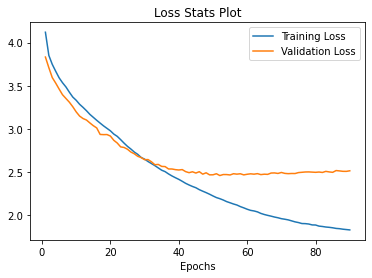

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy: 50.5%


In [23]:
from tqdm.notebook import tqdm

training_losses = []
val_losses = []

for ep in range(EPOCHS):
    
    epoch_loss = 0
    val_loss = 0
    model.train()
    for ims, labs in tqdm(loaders['train']):
        opt.zero_grad(set_to_none=True)
        with autocast():
            out = model(ims)
            loss = loss_fn(out, labs)
            epoch_loss += loss.item()
            
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
    scheduler.step()
    print(scheduler.get_last_lr(), ep)
    
    model.eval()
    with torch.no_grad():
        for ims, labs in tqdm(loaders['test']):
            with autocast():
                out = model(ims)
                loss = loss_fn(out, labs)
                val_loss += loss.item()
      
    epoch_loss = epoch_loss/ len(loaders['train'])
    val_loss = val_loss / len(loaders['test'])
    
    training_losses.append(epoch_loss)
    val_losses.append(val_loss)
    print( f'Epoch: {ep}  Training loss: {epoch_loss} Val loss: {val_loss}')

plot_train_val(training_losses, val_losses)

model.eval()
with ch.no_grad():
    total_correct, total_num = 0., 0.
    for ims, labs in tqdm(loaders['test']):
        with autocast():
            out = model(ims)   #(model(ims) + model(ch.fliplr(ims))) / 2. # Test-time augmentation
            total_correct += out.argmax(1).eq(labs).sum().cpu().item()
            total_num += ims.shape[0]

    print(f'Accuracy: {total_correct / total_num * 100:.1f}%')